Code for making the Cross Section swaths with microseisms & focal mechanisms:

In [2]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from obspy.imaging.beachball import beach

# ─── Configuration ────────────────────────────────────────────────────────
focal_path          = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/new_mechanisms copy.txt"
quake_path          = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/NCEDC_complete_catalog.3693934 copy.txt"
aoi_kml_path        = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/AOI copy.kml"
cross_section_csv   = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/CrossSectionExtents copy.csv"
png_folder          = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/CrossSections copy"
output_folder       = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity"
os.makedirs(output_folder, exist_ok=True)

# ─── Helper Functions ─────────────────────────────────────────────────────
def latlon_to_utm(lat, lon, zone=10):
    transformer = Transformer.from_crs("epsg:4326", f"+proj=utm +zone={zone} +datum=WGS84", always_xy=True)
    return transformer.transform(lon, lat)

def compute_proj_perp(p, start_pt, v, v_norm):
    w = p - start_pt
    proj = np.dot(w, v) / v_norm
    cross = np.cross(np.append(v, 0), np.append(w, 0))
    perp = np.linalg.norm(cross) / v_norm
    return proj, perp

def sdr_to_mt(strike, dip, rake):
    """
    Convert (strike, dip, rake) → full 3×3 moment‐tensor (Aki & Richards convention).
    """
    φ = np.radians(strike)
    δ = np.radians(dip)
    λ = np.radians(rake)
    # fault‐normal vector
    n = np.array([
        -np.sin(δ)*np.sin(φ),
         np.sin(δ)*np.cos(φ),
        -np.cos(δ)
    ])
    # slip vector
    s = np.array([
         np.cos(λ)*np.cos(φ) + np.sin(λ)*np.cos(δ)*np.sin(φ),
         np.cos(λ)*np.sin(φ) - np.sin(λ)*np.cos(δ)*np.cos(φ),
        -np.sin(λ)*np.sin(δ)
    ])
    return np.outer(n, s) + np.outer(s, n)

def rotation_matrix(axis, theta):
    """
    Rodrigues’ rotation formula: rotate by `theta` about `axis`.
    """
    axis = axis / np.linalg.norm(axis)
    a = np.cos(theta/2.0)
    b, c, d = -axis * np.sin(theta/2.0)
    return np.array([
        [ a*a + b*b - c*c - d*d, 2*(b*c - a*d),       2*(b*d + a*c)     ],
        [ 2*(b*c + a*d),         a*a + c*c - b*b - d*d, 2*(c*d - a*b)   ],
        [ 2*(b*d - a*c),         2*(c*d + a*b),       a*a + d*d - b*b - c*c]
    ])

# ─── Load Focal Mechanism Catalog ─────────────────────────────────────────
focals = pd.read_fwf(
    focal_path,
    colspecs=[(0,4),(4,8),(9,13),(14,19),(20,22),(23,28),
              (29,32),(33,39),(40,46),(48,52),(83,86),(87,89),(89,93)],
    header=None,
    names=["Year","MonthDay","HourMinute","OriginSeconds",
           "LatDeg","LatMin","LonDeg","LonMin","Depth","Mag",
           "Strike","Dip","Rake"]
)
focals["latitude"]  = focals.LatDeg + focals.LatMin/60
focals["longitude"] = -(focals.LonDeg + focals.LonMin/60)
gdf_focals = gpd.GeoDataFrame(
    focals,
    geometry=gpd.points_from_xy(focals.longitude, focals.latitude),
    crs="EPSG:4326"
)

# ─── Load AOI and Filter ──────────────────────────────────────────────────
gdf_aoi     = gpd.read_file(aoi_kml_path)
aoi_union   = gdf_aoi.unary_union
gdf_focals  = gdf_focals[gdf_focals.within(aoi_union)]
focals      = pd.DataFrame(gdf_focals.drop(columns="geometry")).reset_index(drop=True)

# ─── UTM Conversion ───────────────────────────────────────────────────────
utm_coords = focals.apply(lambda r: latlon_to_utm(r.latitude, r.longitude), axis=1)
focals[["easting","northing"]] = pd.DataFrame(utm_coords.tolist(), index=focals.index)
focals["depth_m"] = -1000 * focals.Depth

# ─── Load Earthquake Catalog ──────────────────────────────────────────────
quakes = pd.read_csv(quake_path, delim_whitespace=True, comment="#", header=0)
quakes = quakes.rename(columns={'Lat':'latitude','Lon':'longitude','Depth':'depth_km','Mag':'Mag'})
quakes = quakes.dropna(subset=["latitude","longitude","depth_km","Mag"])
gdf_quake = gpd.GeoDataFrame(
    quakes,
    geometry=gpd.points_from_xy(quakes.longitude, quakes.latitude),
    crs="EPSG:4326"
)
gdf_quake = gdf_quake[gdf_quake.within(aoi_union)]
quakes = pd.DataFrame(gdf_quake.drop(columns="geometry"))
utm_coords_q = quakes.apply(lambda r: latlon_to_utm(r.latitude, r.longitude), axis=1)
quakes[["easting","northing"]] = pd.DataFrame(utm_coords_q.tolist(), index=quakes.index)
quakes["depth_m"] = -1000 * quakes.depth_km

# ─── Load Cross Sections ──────────────────────────────────────────────────
sections = pd.read_csv(cross_section_csv)

# ─── Loop Over Sections ───────────────────────────────────────────────────
for _, row in sections.iterrows():
    name      = row["name"]
    base      = os.path.splitext(name)[0]
    utm_min   = row["utm_x_min"]; utm_max = row["utm_x_max"]
    y_min     = row["utm_y_min"]; y_max   = row["utm_y_max"]
    depth_min = row["depth_m_min"]; depth_max = row["depth_m_max"]

    start_pt  = np.array([utm_min, y_min])
    end_pt    = np.array([utm_max, y_max])
    v         = end_pt - start_pt
    v_norm    = np.linalg.norm(v)

    # build rotation R that tilts section vertical plane to horizontal
    axis_section = np.array([v[0], v[1], 0.0]) / v_norm
    R = rotation_matrix(axis_section, np.pi/2.0)

    # project focals & quakes into along/perp
    focals[["along_section_m","perpendicular_m"]] = focals.apply(
        lambda r: compute_proj_perp(np.array([r.easting, r.northing]), start_pt, v, v_norm),
        axis=1, result_type="expand"
    )
    quakes[["along_section_m","perpendicular_m"]] = quakes.apply(
        lambda r: compute_proj_perp(np.array([r.easting, r.northing]), start_pt, v, v_norm),
        axis=1, result_type="expand"
    )

    sel_focals = focals[np.abs(focals.perpendicular_m) <= 1000]
    sel_quakes = quakes[np.abs(quakes.perpendicular_m)   <= 1000]

    png_path    = os.path.join(png_folder, name)
    output_path = os.path.join(output_folder, f"{base}_focals_seismicity.png")

    fig, ax = plt.subplots(figsize=(12,6))
    if os.path.exists(png_path):
        img = plt.imread(png_path)
        ax.imshow(img, extent=[0, v_norm, depth_min, depth_max], origin="upper", aspect="equal")
    else:
        ax.set_facecolor("white")

    # ─── Plot rotated focal beach‐balls ─────────────────────────────────────
    if not sel_focals.empty:
        for _, r in sel_focals.iterrows():
            if pd.isna(r.Mag):
                continue
            size = 300 + 75*r.Mag
            # 1) moment tensor from sdr
            M     = sdr_to_mt(r.Strike, r.Dip, r.Rake)
            # 2) rotate into section‐horizontal
            M_rot = -(R @ M @ R.T)
            # 3) Voigt notation
            mt6 = [M_rot[0,0], M_rot[1,1], M_rot[2,2],
                   M_rot[0,1], M_rot[0,2], M_rot[1,2]]
            # 4) plot
            mb = beach(
                mt6,
                xy=(r.along_section_m, r.depth_m),
                width=size,
                linewidth=0.5,
                facecolor="k",
                edgecolor="k"
            )
            ax.add_collection(mb)

    # ─── Plot seismicity circles ─────────────────────────────────────────────
    if not sel_quakes.empty:
        mags        = sel_quakes.Mag
        sizes       = 15 + (mags**3)*1.8
        norm_colors = mags / mags.max()
        ax.scatter(sel_quakes.along_section_m, sel_quakes.depth_m,
                   s=sizes, c=norm_colors, cmap="plasma",
                   edgecolor="black", linewidth=0.3, alpha=0.9)

    ax.set_xlim(min(0, sel_focals.along_section_m.min()-500), max(v_norm, sel_focals.along_section_m.max()+500))
    ax.set_ylim(min(depth_min, sel_focals.depth_m.min()-500), max(depth_max, sel_focals.depth_m.max()+500))
    ax.set_xlabel("Along Section Distance (m)")
    ax.set_ylabel("Elevation / Depth (m)")
    ax.set_title(f"Focal Mechanisms & Seismicity: {base}")
    fig.tight_layout()
    fig.savefig(output_path, dpi=300)
    plt.close(fig)
    print(f"✅ Saved: {output_path}")


/var/folders/c4/fq4v7s5x2zj_1vddktys22c40000gn/T/ipykernel_59856/2406668708.py:84: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_union   = gdf_aoi.unary_union
/var/folders/c4/fq4v7s5x2zj_1vddktys22c40000gn/T/ipykernel_59856/2406668708.py:94: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  quakes = pd.read_csv(quake_path, delim_whitespace=True, comment="#", header=0)


✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_a_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_b_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_c_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_d_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_e_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_f_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputP

Code for making focal mechanisms in map view with section lines

/var/folders/c4/fq4v7s5x2zj_1vddktys22c40000gn/T/ipykernel_59856/709264724.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  gdf = gdf[gdf.within(aoi.unary_union)].reset_index(drop=True)


— skipping clipped_a_san_mateo: no events in swath
— skipping clipped_b_san_mateo: no events in swath


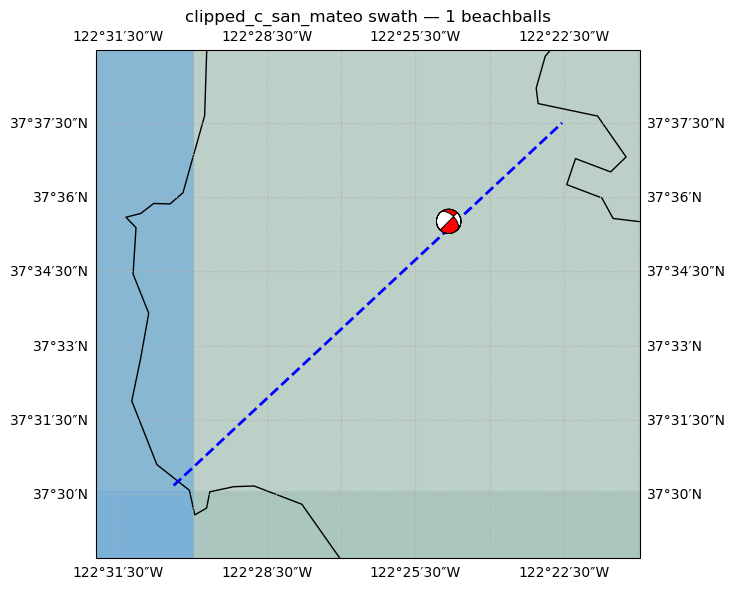

✅ Saved clipped_c_san_mateo_map_swath.png
— skipping clipped_d_san_mateo: no events in swath
— skipping clipped_e_san_mateo: no events in swath


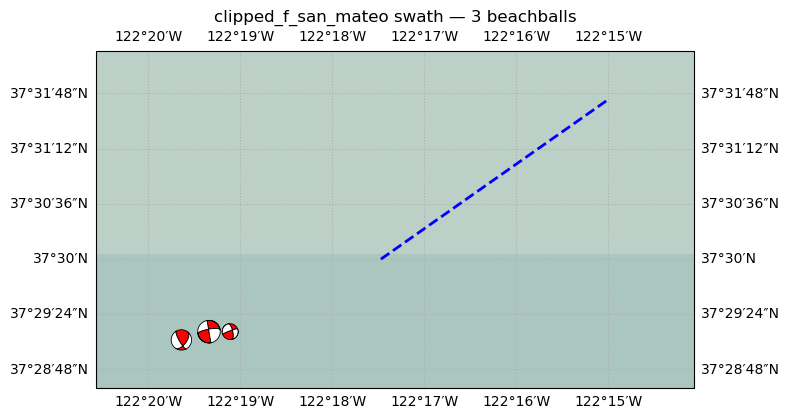

✅ Saved clipped_f_san_mateo_map_swath.png


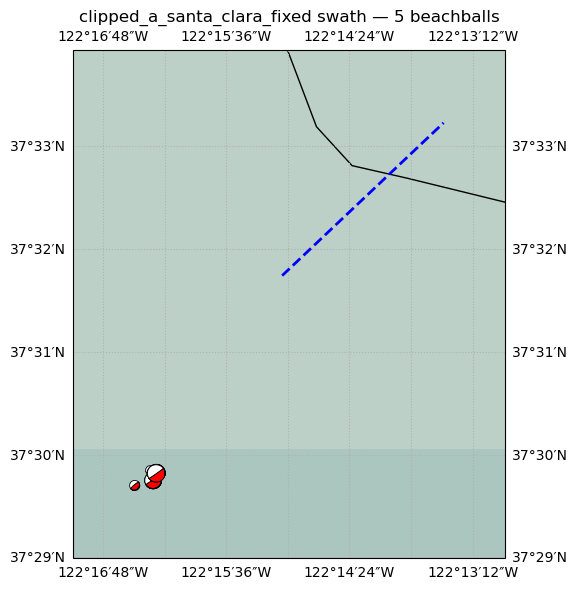

✅ Saved clipped_a_santa_clara_fixed_map_swath.png


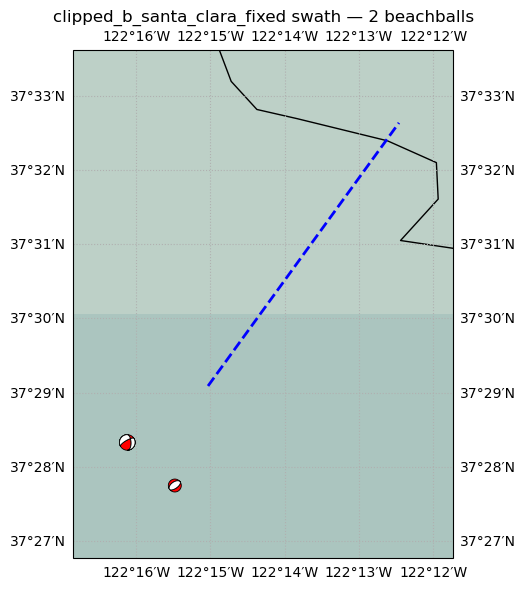

✅ Saved clipped_b_santa_clara_fixed_map_swath.png


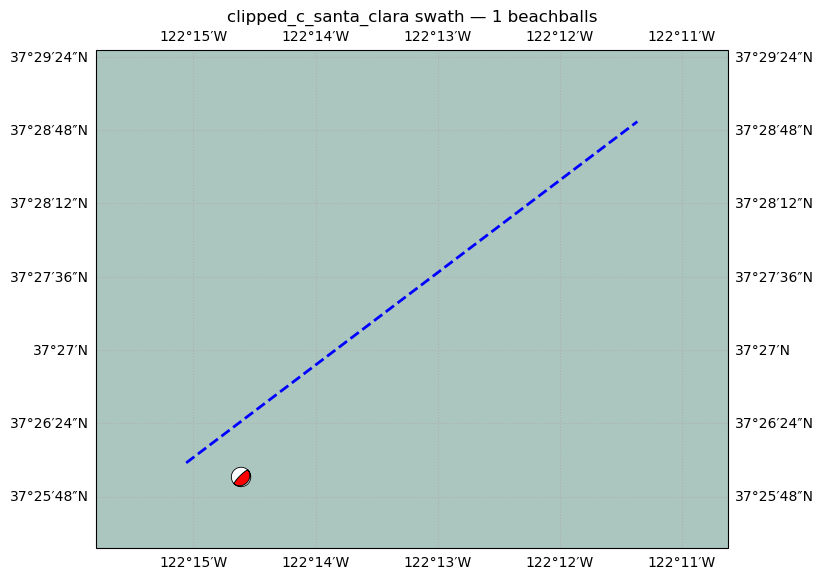

✅ Saved clipped_c_santa_clara_map_swath.png


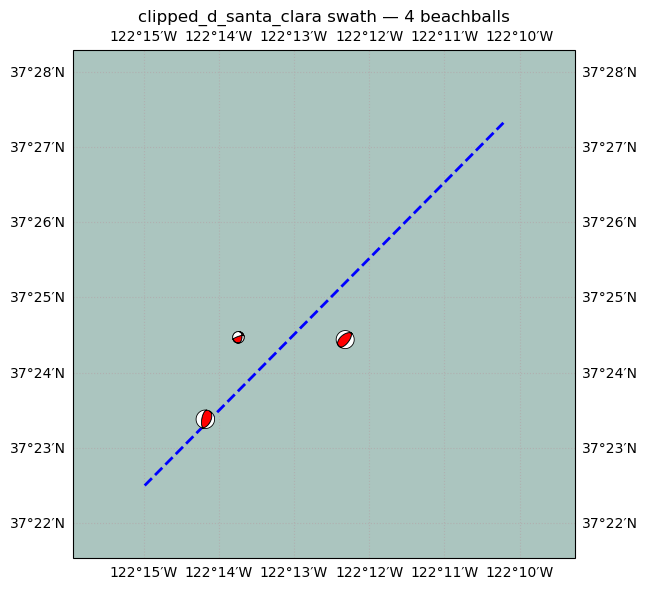

✅ Saved clipped_d_santa_clara_map_swath.png


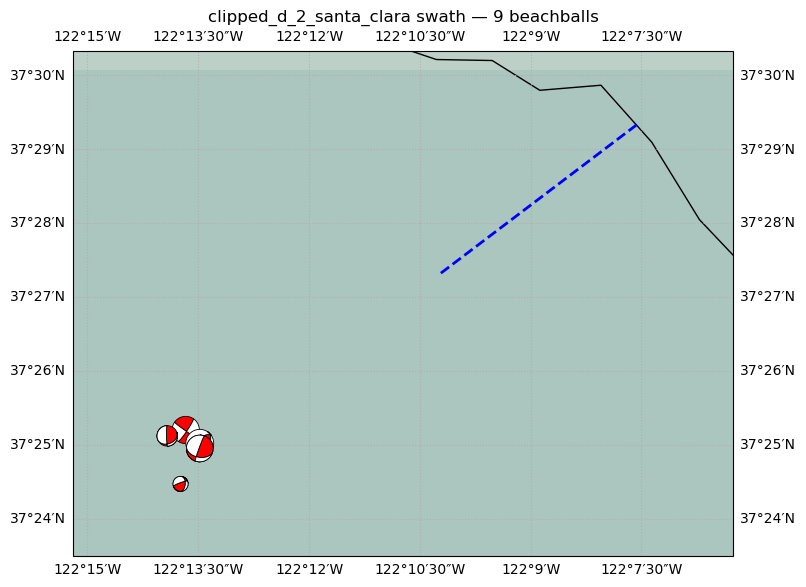

✅ Saved clipped_d_2_santa_clara_map_swath.png


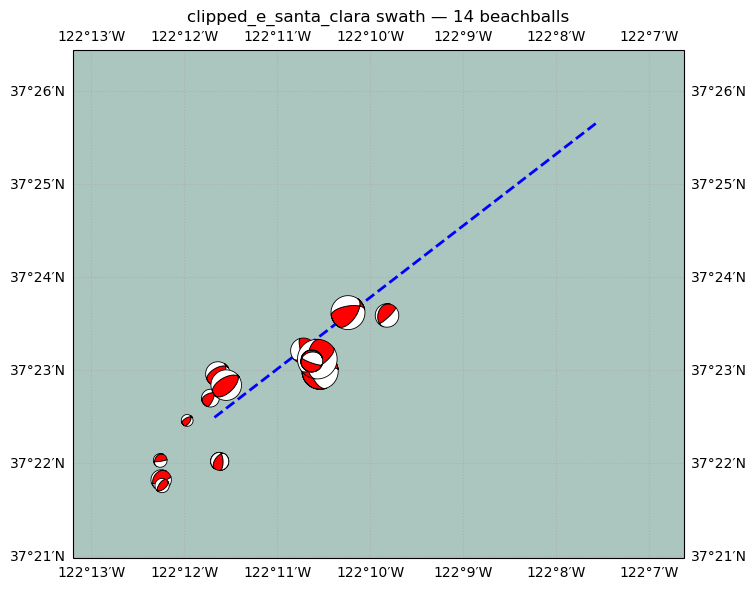

✅ Saved clipped_e_santa_clara_map_swath.png


In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from obspy.imaging.beachball import beach
from pyproj import Transformer

# ─── Configuration ────────────────────────────────────────────────────────
focal_path        = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/new_mechanisms copy.txt"
aoi_kml_path      = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/AOI copy.kml"
cross_section_csv = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/CrossSectionExtents copy.csv"
output_folder     = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Map_BySection"
os.makedirs(output_folder, exist_ok=True)

# ─── 1) Load & AOI-filter focal mechanisms ────────────────────────────────
colspecs = [(0,4),(4,8),(9,13),(14,19),(20,22),(23,28),
            (29,32),(33,39),(40,46),(48,52),(83,86),(87,89),(89,93)]
names    = ["Year","MonthDay","HourMinute","OriginSeconds",
            "LatDeg","LatMin","LonDeg","LonMin",
            "Depth_km","Mag","Strike","Dip","Rake"]
df = pd.read_fwf(focal_path, colspecs=colspecs, header=None, names=names)
df["latitude"]  = df.LatDeg + df.LatMin/60.0
df["longitude"] = -(df.LonDeg + df.LonMin/60.0)

gdf = gpd.GeoDataFrame(df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)
aoi = gpd.read_file(aoi_kml_path)
gdf = gdf[gdf.within(aoi.unary_union)].reset_index(drop=True)
if gdf.empty:
    raise RuntimeError("No focal mechanisms within AOI!")
focals = pd.DataFrame(gdf.drop(columns="geometry"))

# ─── 2) Convert lat/lon → UTM & compute depth ────────────────────────────
zone = 10
to_utm = Transformer.from_crs("epsg:4326",
                             f"+proj=utm +zone={zone} +datum=WGS84",
                             always_xy=True).transform
utm = focals.apply(lambda r: to_utm(r.longitude, r.latitude),
                   axis=1, result_type="expand")
focals[["easting","northing"]] = utm
focals["depth_m"] = -1000 * focals.Depth_km
max_mag = focals.Mag.max()

# reverse transformer for lon/lat extents & section line
utm2geo = Transformer.from_crs(f"+proj=utm +zone={zone} +datum=WGS84",
                               "epsg:4326",
                               always_xy=True).transform

# ─── 3) Read cross-section definitions ────────────────────────────────────
sections = pd.read_csv(cross_section_csv)

# ─── 4) Loop & plot each section in MAP VIEW ─────────────────────────────
for _, row in sections.iterrows():
    sec = os.path.splitext(row["name"])[0]

    # compute section endpoints & direction vector in UTM
    start = np.array([row["utm_x_min"], row["utm_y_min"]])
    end   = np.array([row["utm_x_max"], row["utm_y_max"]])
    v     = end - start
    L     = np.linalg.norm(v)

    # function to project into along/perp
    def project(pt):
        w     = pt - start
        along = np.dot(w, v) / L
        perp  = np.linalg.norm(np.cross(np.append(v,0), np.append(w,0))) / L
        return along, perp

    # project focals
    proj = focals.apply(
        lambda r: project(np.array([r.easting, r.northing])),
        axis=1, result_type="expand"
    )
    focals[["along_m","perp_m"]] = proj

    # select within ±1 km
    sel = focals[np.abs(focals.perp_m) <= 1000]
    if sel.empty:
        print(f"— skipping {sec}: no events in swath")
        continue

    # convert section endpoints to lon/lat
    lon0, lat0 = utm2geo(*start)
    lon1, lat1 = utm2geo(*end)

    # determine extent: include both events AND section endpoints
    lon_vals = np.concatenate([sel.longitude.values, [lon0, lon1]])
    lat_vals = np.concatenate([sel.latitude.values,  [lat0, lat1]])
    lon_min, lon_max = lon_vals.min(), lon_vals.max()
    lat_min, lat_max = lat_vals.min(), lat_vals.max()
    buf_lon = (lon_max - lon_min) * 0.2
    buf_lat = (lat_max - lat_min) * 0.2
    extent = [lon_min-buf_lon, lon_max+buf_lon,
              lat_min-buf_lat, lat_max+buf_lat]

    # ─── Create GeoAxes ────────────────────────────────────────────────────
    fig, ax = plt.subplots(
        figsize=(8,6),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )
    ax.set_extent(extent, ccrs.PlateCarree())

    # background + coastlines + borders + grid
    ax.stock_img()
    ax.coastlines(resolution="10m")
    ax.add_feature(cfeature.BORDERS.with_scale("10m"), linestyle=":")
    ax.gridlines(draw_labels=True, dms=True, linestyle=":")

    # ─── Plot section line ────────────────────────────────────────────────
    ax.plot(
        [lon0, lon1], [lat0, lat1],
        transform=ccrs.PlateCarree(),
        color="blue", linewidth=2, linestyle="--",
        zorder=4
    )

    # ─── Plot beachballs ─────────────────────────────────────────────────
    for r in sel.itertuples():
        width = (r.Mag / max_mag) * (extent[1] - extent[0]) * 0.1
        bb = beach(
            [r.Strike, r.Dip, r.Rake],
            xy=(r.longitude, r.latitude),
            width=width, linewidth=0.6,
            facecolor="red", edgecolor="black"
        )
        bb.set_transform(ccrs.PlateCarree())
        bb.set_zorder(5)
        ax.add_collection(bb)

    ax.set_title(f"{sec} swath — {len(sel)} beachballs")
    plt.tight_layout()

    out_png = os.path.join(output_folder, f"{sec}_map_swath.png")
    fig.savefig(out_png, dpi=300)
    plt.show()
    plt.close(fig)
    print(f"✅ Saved {sec}_map_swath.png")


In [8]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
import numpy as np
from obspy.imaging.beachball import beach

# <-- replace `yourmodule` with the actual module name where you defined rotate_moment_tensor -->
from rotate_beachball import rotate_moment_tensor  

# ─── Configuration ────────────────────────────────────────────────────────
focal_path          = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/new_mechanisms copy.txt"
quake_path          = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/NCEDC_complete_catalog.3693934 copy.txt"
aoi_kml_path        = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/AOI copy.kml"
cross_section_csv   = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/CrossSectionExtents copy.csv"
png_folder          = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/CrossSections copy"
output_folder       = "/Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity"
os.makedirs(output_folder, exist_ok=True)

# ─── Helper Functions ─────────────────────────────────────────────────────
def latlon_to_utm(lat, lon, zone=10):
    transformer = Transformer.from_crs("epsg:4326", f"+proj=utm +zone={zone} +datum=WGS84", always_xy=True)
    return transformer.transform(lon, lat)

def compute_proj_perp(p, start_pt, v, v_norm):
    w = p - start_pt
    proj = np.dot(w, v) / v_norm
    cross = np.cross(np.append(v, 0), np.append(w, 0))
    perp = np.linalg.norm(cross) / v_norm
    return proj, perp

# ─── Load Focal Mechanism Catalog ─────────────────────────────────────────
focals = pd.read_fwf(
    focal_path,
    colspecs=[(0,4),(4,8),(9,13),(14,19),(20,22),(23,28),
              (29,32),(33,39),(40,46),(48,52),(83,86),(87,89),(89,93)],
    header=None,
    names=["Year","MonthDay","HourMinute","OriginSeconds",
           "LatDeg","LatMin","LonDeg","LonMin","Depth","Mag",
           "Strike","Dip","Rake"]
)
focals["latitude"]  = focals.LatDeg + focals.LatMin/60
focals["longitude"] = -(focals.LonDeg + focals.LonMin/60)
gdf_focals = gpd.GeoDataFrame(
    focals,
    geometry=gpd.points_from_xy(focals.longitude, focals.latitude),
    crs="EPSG:4326"
)

# ─── Load AOI and Filter ──────────────────────────────────────────────────
gdf_aoi     = gpd.read_file(aoi_kml_path)
aoi_union   = gdf_aoi.unary_union
gdf_focals  = gdf_focals[gdf_focals.within(aoi_union)]
focals      = pd.DataFrame(gdf_focals.drop(columns="geometry")).reset_index(drop=True)

# ─── UTM Conversion ───────────────────────────────────────────────────────
utm_coords = focals.apply(lambda r: latlon_to_utm(r.latitude, r.longitude), axis=1)
focals[["easting","northing"]] = pd.DataFrame(utm_coords.tolist(), index=focals.index)
focals["depth_m"] = -1000 * focals.Depth
max_mag = focals.Mag.max()

# ─── Load Earthquake Catalog ──────────────────────────────────────────────
quakes = pd.read_csv(quake_path, delim_whitespace=True, comment="#", header=0)
quakes = quakes.rename(columns={'Lat':'latitude','Lon':'longitude','Depth':'depth_km','Mag':'Mag'})
quakes = quakes.dropna(subset=["latitude","longitude","depth_km","Mag"])
gdf_quake = gpd.GeoDataFrame(
    quakes,
    geometry=gpd.points_from_xy(quakes.longitude, quakes.latitude),
    crs="EPSG:4326"
)
gdf_quake = gdf_quake[gdf_quake.within(aoi_union)]
quakes = pd.DataFrame(gdf_quake.drop(columns="geometry"))
utm_coords_q = quakes.apply(lambda r: latlon_to_utm(r.latitude, r.longitude), axis=1)
quakes[["easting","northing"]] = pd.DataFrame(utm_coords_q.tolist(), index=quakes.index)
quakes["depth_m"] = -1000 * quakes.depth_km

# ─── Load Cross Sections ──────────────────────────────────────────────────
sections = pd.read_csv(cross_section_csv)

# ─── Loop Over Sections ───────────────────────────────────────────────────
for _, row in sections.iterrows():
    name      = row["name"]
    base      = os.path.splitext(name)[0]
    utm_min   = row["utm_x_min"]; utm_max = row["utm_x_max"]
    y_min     = row["utm_y_min"]; y_max   = row["utm_y_max"]
    depth_min = row["depth_m_min"]; depth_max = row["depth_m_max"]

    start_pt  = np.array([utm_min, y_min])
    end_pt    = np.array([utm_max, y_max])
    v         = end_pt - start_pt
    v_norm    = np.linalg.norm(v)

    # project focals & quakes into along/perp
    focals[["along_section_m","perpendicular_m"]] = focals.apply(
        lambda r: compute_proj_perp(np.array([r.easting, r.northing]), start_pt, v, v_norm),
        axis=1, result_type="expand"
    )
    quakes[["along_section_m","perpendicular_m"]] = quakes.apply(
        lambda r: compute_proj_perp(np.array([r.easting, r.northing]), start_pt, v, v_norm),
        axis=1, result_type="expand"
    )

    sel_focals = focals[np.abs(focals.perpendicular_m) <= 1000]
    sel_quakes = quakes[np.abs(quakes.perpendicular_m)   <= 1000]

    png_path    = os.path.join(png_folder, name)
    output_path = os.path.join(output_folder, f"{base}_focals_seismicity.png")

    fig, ax = plt.subplots(figsize=(12,6))
    if os.path.exists(png_path):
        img = plt.imread(png_path)
        ax.imshow(img, extent=[0, v_norm, depth_min, depth_max], origin="upper", aspect="equal")
    else:
        ax.set_facecolor("white")

    # ─── Plot rotated focal beach‐balls with rotate_moment_tensor ──────────
    if not sel_focals.empty:
        # axis for rotation: section direction in UTM is [easting, northing]; convert to NED order (North, East, Down)
        # v is [delta_easting, delta_northing]; so north component is v[1], east is v[0]
        axis_section_ned = np.array([v[1], v[0], 0.0]) / v_norm
        for _, r in sel_focals.iterrows():
            if pd.isna(r.Mag):
                continue
            size = 300 + 75 * r.Mag
            # rotate moment tensor into cross-section-horizontal view
            mt6 = rotate_moment_tensor(
                r.Strike, r.Dip, r.Rake,
                axis_section_ned, 90.0,
                use_upper_hemisphere=True
            )
            mb = beach(
                mt6,
                xy=(r.along_section_m, r.depth_m),
                width=size,
                linewidth=0.5,
                facecolor="k",
                edgecolor="k"
            )
            ax.add_collection(mb)

    # ─── Plot seismicity circles ─────────────────────────────────────────────
    if not sel_quakes.empty:
        mags        = sel_quakes.Mag
        sizes       = 15 + (mags**3)*1.8
        norm_colors = mags / mags.max()
        ax.scatter(sel_quakes.along_section_m, sel_quakes.depth_m,
                   s=sizes, c=norm_colors, cmap="plasma",
                   edgecolor="black", linewidth=0.3, alpha=0.9)

    ax.set_xlim(min(0, sel_focals.along_section_m.min()-500), max(v_norm, sel_focals.along_section_m.max()+500))
    ax.set_ylim(min(depth_min, sel_focals.depth_m.min()-500), max(depth_max, sel_focals.depth_m.max()+500))
    ax.set_xlabel("Along Section Distance (m)")
    ax.set_ylabel("Elevation / Depth (m)")
    ax.set_title(f"Focal Mechanisms & Seismicity: {base}")
    fig.tight_layout()
    fig.savefig(output_path, dpi=300)
    plt.close(fig)
    print(f"✅ Saved: {output_path}")


/var/folders/c4/fq4v7s5x2zj_1vddktys22c40000gn/T/ipykernel_59856/1439726415.py:53: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_union   = gdf_aoi.unary_union
/var/folders/c4/fq4v7s5x2zj_1vddktys22c40000gn/T/ipykernel_59856/1439726415.py:64: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  quakes = pd.read_csv(quake_path, delim_whitespace=True, comment="#", header=0)


✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_a_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_b_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_c_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_d_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_e_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputPNGs_Focals_Seismicity/clipped_f_san_mateo_focals_seismicity.png
✅ Saved: /Users/krodri02/Documents/GitHub/FFTBVisualization/CSVisualizationFiles/OutputP